In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
from pathlib import Path
from typing import List

import os
import hydra
import numpy as np
import torch
import omegaconf
import wandb
import pytorch_lightning as pl


from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning import seed_everything, Callback
from pytorch_lightning.loggers import WandbLogger
from source.common.utils import build_callbacks, log_hyperparameters, PROJECT_ROOT

import torch
import lz4.frame
from tqdm import tqdm
import plotly.graph_objects as go
from IPython.display import Image, display

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device('cuda')

/home/holywater2/.conda/envs/infGCN/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# options = "--config-name=mp_mixed data=all_mp_mixed model=RNO_v8-pbc-soul2 train.random_seed=1 postfix=op2 data.num_workers=16 data=all_mp_mixed logging=draw model.num_fourier=12 model.residual=True model.num_spherical=3 model.num_spherical_RNO=3 model.scalar_mask=False model.grid_cutoff=1.25 model.mask_cutoff=0.5 model.output_positive=True"
# file_path = "/home/holywater2/crystal/InfGCN-pytorch/outputs/hydra/singlerun/2024-01-20-20-03-28/RNO_v8-pbc-soul2_mk-False_co5_pc2.5_gc1.25_f12_t12_w16_gcn2_pd0_sp3_spf3_inp-True_sha-False_max-False_res-True_mc0.5_ff-True_op2/epoch=21-step=9636.ckpt"

In [4]:
options = "--config-name=mp_mixed train.random_seed=2 postfix=rep data.num_workers=32 data=all_mp_mixed logging=draw model.residual=True model.num_spherical=3"
file_path = "/home/holywater2/crystal/InfGCN-pytorch/outputs/hydra/singlerun/2024-01-16-03-25-03/infgcn_co5_gc5.0sp3_gcns3_resTrue_rep/epoch=21-step=9636.ckpt"

In [5]:
# options = "--config-name=mp_mixed data=all_mp_mixed model=RNO_v8-pbc-soul2 train.random_seed=42 postfix=plz data.num_workers=32 data=all_mp_mixed logging=draw model.num_fourier=12 model.residual=True model.num_spherical=3 model.num_spherical_RNO=3 model.scalar_mask=True model.grid_cutoff=1.25 model.mask_cutoff=0.5"
# file_path = "/home/holywater2/crystal/InfGCN-pytorch/outputs/hydra/singlerun/2024-01-18-19-09-51/RNO_v8-pbc-soul2_mk-True_co5_pc2.5_gc1.25_f12_t12_w16_gcn2_pd0_sp3_spf3_inp-True_sha-False_max-False_res-True_mc0.5_ff-True_plz/epoch=21-step=9636.ckpt"

In [6]:
# options = "--config-name=mp_mixed data=all_mp_mixed model=RNO_v8-pbc-soul2 train.random_seed=42 postfix=plz data.num_workers=32 data=all_mp_mixed logging=draw model.num_fourier=12 model.residual=True model.num_spherical=3 model.num_spherical_RNO=3 model.scalar_mask=False model.grid_cutoff=1.25 model.mask_cutoff=1.5"
# file_path = "/home/holywater2/crystal/InfGCN-pytorch/outputs/hydra/singlerun/2024-01-18-18-35-53/RNO_v8-pbc-soul2_mk-False_co5_pc2.5_gc1.25_f12_t12_w16_gcn2_pd0_sp3_spf3_inp-True_sha-False_max-False_res-True_mc1.5_ff-True_plz/epoch=21-step=9636.ckpt"

In [7]:
# options = "-config-name=mp_mixed data=all_mp_mixed model=RNO_v8-pbc-soul2 train.random_seed=2 postfix=plz data.num_workers=32 data=all_mp_mixed logging=draw model.num_fourier=12 model.residual=True model.num_spherical=3 model.num_spherical_RNO=3 model.scalar_mask=False model.grid_cutoff=1.25 model.mask_cutoff=1.5"
# file_path = "/home/holywater2/crystal/InfGCN-pytorch/outputs/hydra/singlerun/2024-01-19-19-42-46/RNO_v8-pbc-soul2_mk-False_co5_pc2.5_gc1.25_f12_t12_w16_gcn2_pd0_sp3_spf3_inp-True_sha-False_max-False_res-True_mc1.5_ff-True_plz/epoch=21-step=9636.ckpt"

In [8]:
# random_seed = 2

In [9]:
from hydra import compose, initialize
from omegaconf import OmegaConf


# context initialization
# https://hydra.cc/docs/advanced/compose_api/

file_path_upd = file_path.replace("=","\\=")
overrides = options.split()
test_num_samples = 10
overrides.append(f"+data.datamodule.datasets.test.num_samples={test_num_samples}")
overrides.append(f"+model.checkpoint_path={file_path_upd}")
if overrides[0].find("config-name") != -1:
    config_name = overrides[0].split("=")[1]
    overrides = overrides[1:]
else:
    config_name = "default"

with initialize(config_path="conf"):
    cfg = compose(config_name=config_name, overrides=overrides, return_hydra_config=True)
    print(OmegaConf.to_yaml(cfg))

/tmp/ipykernel_1791831/366030816.py:19: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="conf"):


/home/holywater2/.conda/envs/infGCN/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'mp_mixed': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


hydra:
  run:
    dir: ${oc.env:HYDRA_JOBS}/singlerun/${now:%Y-%m-%d-%H-%M-%S}/${expname}/
  sweep:
    dir: ${oc.env:HYDRA_JOBS}/multirun/${now:%Y-%m-%d}/${expname}/
    subdir: ${hydra.job.num}_${hydra.job.id}
  launcher:
    _target_: hydra._internal.core_plugins.basic_launcher.BasicLauncher
  sweeper:
    _target_: hydra._internal.core_plugins.basic_sweeper.BasicSweeper
    max_batch_size: null
    params: null
  help:
    app_name: ${hydra.job.name}
    header: '${hydra.help.app_name} is powered by Hydra.

      '
    footer: 'Powered by Hydra (https://hydra.cc)

      Use --hydra-help to view Hydra specific help

      '
    template: '${hydra.help.header}

      == Configuration groups ==

      Compose your configuration from those groups (group=option)


      $APP_CONFIG_GROUPS


      == Config ==

      Override anything in the config (foo.bar=value)


      $CONFIG


      ${hydra.help.footer}

      '
  hydra_help:
    template: 'Hydra (${hydra.runtime.version})

      Se

In [10]:
datamodule: pl.LightningDataModule = hydra.utils.instantiate(
    cfg.data.datamodule, _recursive_=False
)

""" Instantiate model """
hydra.utils.log.info(f"Instantiating <{cfg.model._target_}>")
model: pl.LightningModule = hydra.utils.instantiate(
    cfg.model,
    optim=cfg.optim,
    data=cfg.data,
    logging=cfg.logging,
    _recursive_=False,
)

/home/holywater2/.conda/envs/infGCN/lib/python3.9/site-packages/torch/jit/_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


In [11]:
model = model.__class__.load_from_checkpoint(
    checkpoint_path=cfg.model.checkpoint_path,
)

/home/holywater2/.conda/envs/infGCN/lib/python3.9/site-packages/pytorch_lightning/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.1.3, which is newer than your current Lightning version: v2.1.2


In [12]:
HydraConfig.instance().set_config(cfg)
callbacks: List[Callback] = build_callbacks(cfg=cfg)

""" Hydra run directory """
hydra_dir = Path(HydraConfig.get().run.dir)

wandb_logger = None

# if "wandb" in cfg.logging:
#         hydra.utils.log.info("Instantiating <WandbLogger>")
#         wandb_config = cfg.logging.wandb
#         wandb_logger = WandbLogger(
#             **wandb_config,
#             save_dir=hydra_dir,
#             tags=cfg.core.tags,
#         )
#         hydra.utils.log.info("W&B is now watching <{cfg.logging.wandb_watch.log}>!")
#         wandb_logger.watch(
#             model,
#             log=cfg.logging.wandb_watch.log,
#             log_freq=cfg.logging.wandb_watch.log_freq,
#         )


In [13]:
trainer = pl.Trainer(
    accelerator="auto",
    default_root_dir=hydra_dir,
    logger=wandb_logger,
    callbacks=callbacks,
    deterministic=cfg.train.deterministic,
    # check_val_every_n_epoch=cfg.logging.val_check_interval,
    log_every_n_steps=1,
    **cfg.train.pl_trainer,  # max_steps 포함
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
datamodule.setup()
test_data_loader = datamodule.test_dataloader()
save_dic = "../outputs_res"
len(test_data_loader)

10

In [15]:
hydra.utils.log.info("Starting testing!")
pred = trainer.predict(model=model, dataloaders=test_data_loader)
torch.save(pred, save_dic + "/" + cfg.model.name +"_pred.pt")

You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /home/holywater2/crystal/InfGCN-pytorch/outputs/hydra/singlerun/2024-01-22-08-27-41/infgcn_co5_gc5.0sp3_gcns3_resTrue_rep/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 10/10 [01:48<00:00,  0.09it/s]


PREDICT Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                            	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                             	|  -              	|  221    

In [16]:
save_dic = "../outputs_res"
pred = torch.load(save_dic + "/" + cfg.model.name +"_pred.pt")

In [17]:
pred[1]["density"].shape

torch.Size([1, 16003008])

In [18]:
cfg.model.name

'infgcn_co5_gc5.0sp3_gcns3_resTrue'

In [19]:
def dist_grid_helper(pred,idx=0):
    grid = pred[idx]["grid_coord"]
    atom_coords = pred[idx]["atom_coord"]
    cell = pred[idx]["cell"][0]
    dist = dist_grid(grid, atom_coords, cell)
    return dist

def dist_grid(grid, atom_coords, cell):
    cell_shift = torch.stack([
        i * cell[0] 
        + j * cell[1] 
        + k * cell[2] 
        for i in [-1, 0, 1] 
        for j in [-1, 0, 1] 
        for k in [-1, 0, 1]
        ])
    dist = torch.norm(grid.reshape(1,-1,1,1,3)
    - atom_coords.reshape(1,1,-1,1,3) 
    + cell_shift.reshape(1,1,1,-1,3),dim=-1)
    dist = dist.min(dim=-1)[0]
    dist = dist.min(dim=-1)[0]
    return dist

In [20]:
dist_a = dist_grid_helper(pred,idx=1)

In [21]:
num_bins = 300
def make_hist(dist,num_bins=500,ii=0):
    dist_hist = dist.histogram(num_bins)

    new_pred = torch.zeros_like(dist_hist[0])
    new_scalar = torch.zeros_like(dist_hist[0])
    new_density = torch.zeros_like(dist_hist[0])
    new_diff = torch.zeros_like(dist_hist[0])
    for i in range(num_bins):
        if i == 0:
            idx = dist < dist_hist[1][i]
        else :
            idx = (dist < dist_hist[1][i]) & (dist > dist_hist[1][i-1])
        new_pred[i] = pred[ii]["pred"][idx].mean()
        if pred[ii].keys().__contains__("scalar_field"):
            new_scalar[i] = pred[ii]["scalar_field"][idx].mean()
        new_density[i] = pred[ii]["density"][idx].mean()
        new_diff[i] = (pred[ii]["density"][idx]-pred[ii]["pred"][idx]).mean()
    return dist_hist, new_pred, new_scalar, new_density, new_diff

In [22]:
dist_hist, new_pred, new_scalar, new_density, new_diff = make_hist(dist_a,num_bins,ii=1)

# import json
# save_dic = "outputs_res"
# with open(save_dic + "/" + cfg.model.name +"_make_hist.json", 'w') as f:
#     json.dump([dist_hist, new_pred, new_scalar, new_density, new_diff], f)


In [23]:
# save_dic = "outputs_res"
# with open(save_dic + "/" + cfg.model.name +"_make_hist.json", 'r') as f:
#     dist_hist, new_pred, new_scalar, new_density, new_diff = json.load(f)

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

def draw_statistic(dist_hist, pred, new_pred, new_scalar, new_density, new_diff,
                    tr = lambda x: np.log(abs(x)),
                    xlim=(0,None),
                    ylim=(None,None),
                    save_name="test.png"
                    ):
    plt.figure(figsize=(10,8))
    plt.subplot(2,1,1)
    # tr = lambda x : np.log(abs(x))
    plt.plot(dist_hist[1][1:], tr(new_pred) ,alpha=0.5, markersize=1, label="pred")
    if pred[0].keys().__contains__("scalar_field"):
        plt.plot(dist_hist[1][1:], tr(new_scalar),alpha=0.5, markersize=1, label="scalar")
    plt.plot(dist_hist[1][1:], tr(new_density),alpha=0.5, markersize=1, label="density")
    plt.plot(dist_hist[1][1:], tr(new_diff),alpha=0.5, markersize=1, label="diff")
    plt.legend(loc="upper right")
    plt.ylabel(r"log($\rho$)")
    plt.xlabel("distance")
    plt.xlim(xlim)
    plt.ylim(ylim)

    ax1 = plt.subplot(2,1,2)
    ax1.plot(dist_hist[1][:-1], dist_hist[0]/dist_hist[0].sum(),alpha=0.5, markersize=1, label="density")
    ax2 = ax1.twinx()
    ax2.plot(dist_hist[1][:-1], new_diff*dist_hist[0]/dist_hist[0].sum(),color="red",alpha=0.5, markersize=1, label="density")
    plt.ylim(0, None)
    plt.xlim(xlim)
    plt.ylabel("density")
    plt.xlabel("distance")
    plt.savefig(save_name)
    plt.show()

def draw_statistic_no_abs(dist_hist, pred, new_pred, new_scalar, new_density, new_diff,const=1e0):
    plt.figure(figsize=(10,8))
    plt.subplot(2,1,1)
    tr = lambda x : np.sign(x) * np.log(1+abs(x)/const)
    plt.plot(dist_hist[1][1:], tr(new_pred) ,alpha=0.5, markersize=1, label="pred")
    if pred[0].keys().__contains__("scalar_field"):
        plt.plot(dist_hist[1][1:], tr(new_scalar),alpha=0.5, markersize=1, label="scalar")
    plt.plot(dist_hist[1][1:], tr(new_density),alpha=0.5, markersize=1, label="density")
    plt.plot(dist_hist[1][1:], tr(new_diff),alpha=0.5, markersize=1, label="diff")
    plt.legend(loc="upper right")
    plt.ylabel(r"log($\rho$)")
    plt.xlabel("distance")
    plt.xlim(0, 2)

    ax1 = plt.subplot(2,1,2)
    ax1.plot(dist_hist[1][:-1], dist_hist[0]/dist_hist[0].sum(),alpha=0.5, markersize=1, label="density")
    ax2 = ax1.twinx()
    ax2.plot(dist_hist[1][:-1], new_diff*dist_hist[0],alpha=0.5, markersize=1, label="density")
    plt.ylim(0, None)
    plt.xlim(0, 2)
    plt.ylabel("density")
    plt.xlabel("distance")
    plt.show()

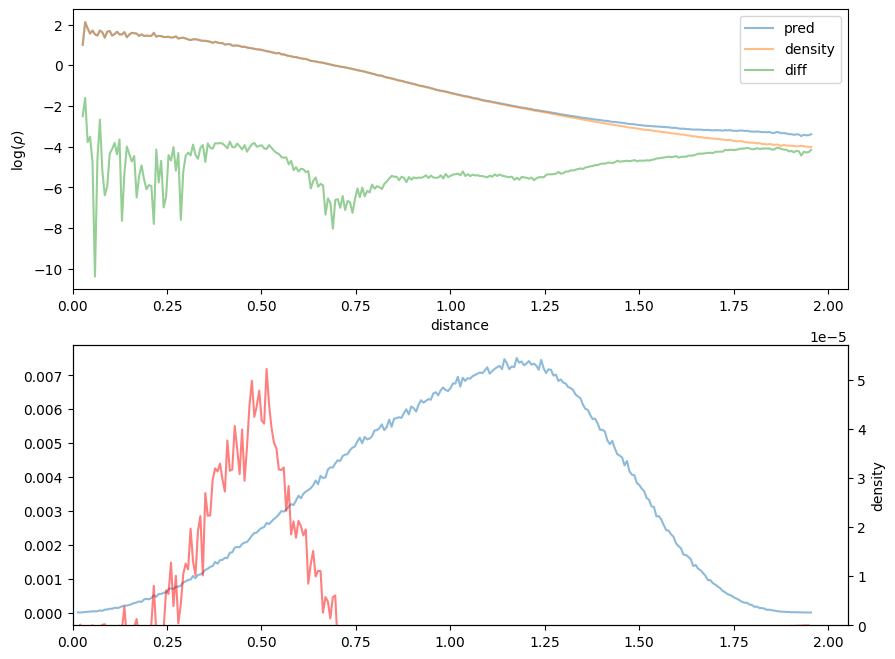

<Figure size 640x480 with 0 Axes>

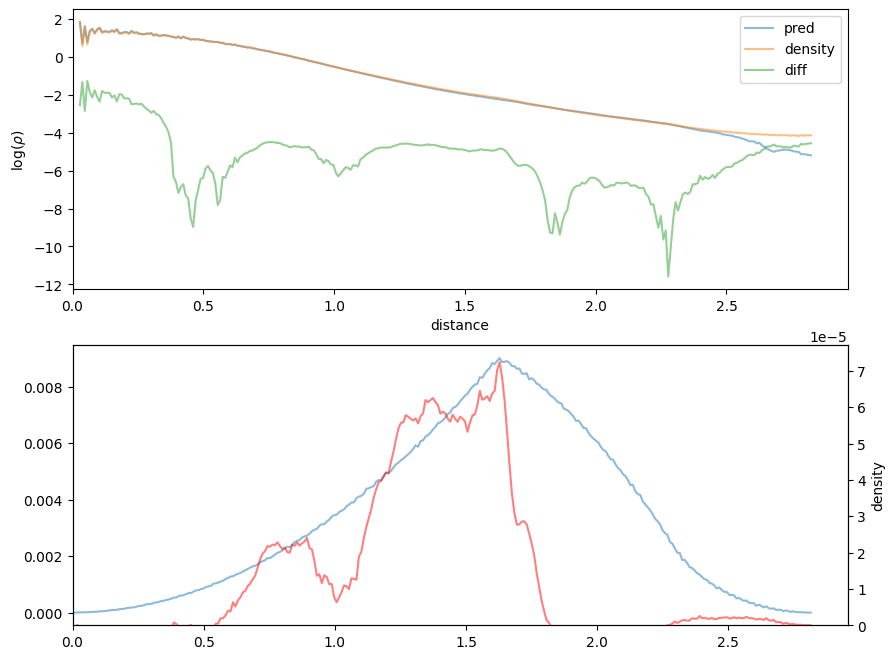

<Figure size 640x480 with 0 Axes>

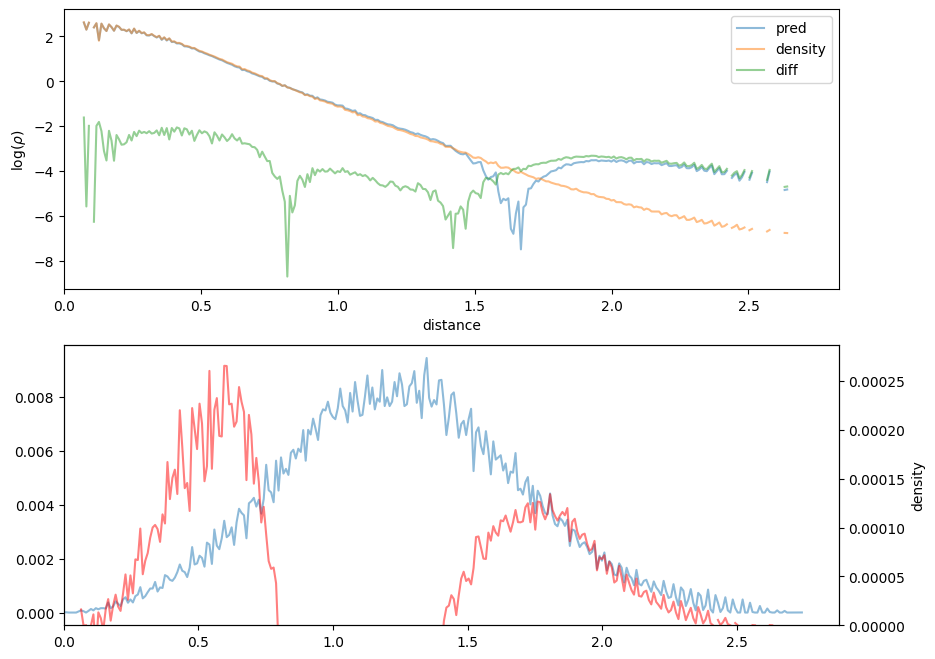

<Figure size 640x480 with 0 Axes>

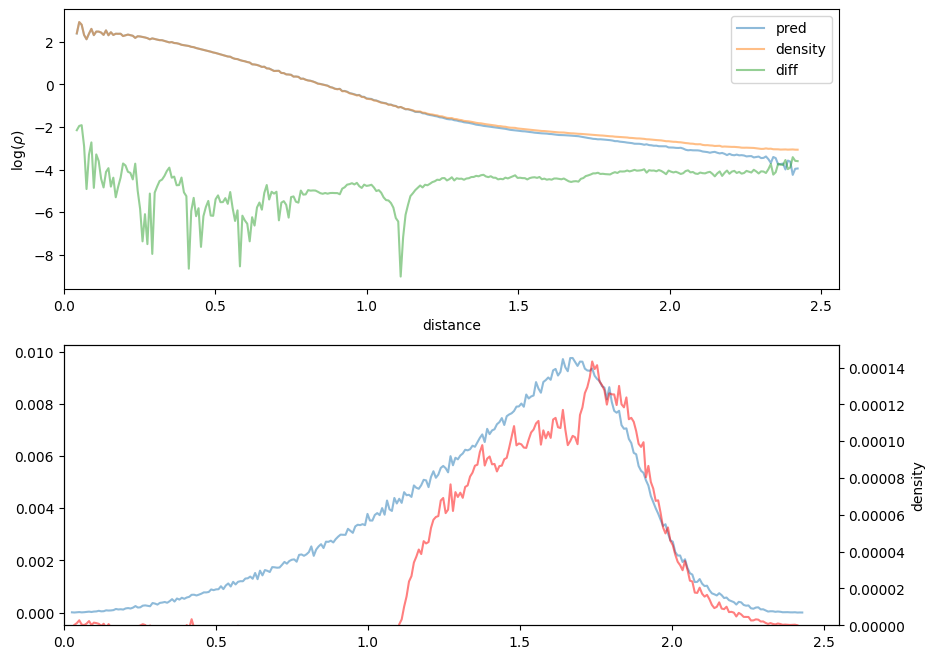

In [26]:
for idx in range(10):
    dist_a = dist_grid_helper(pred,idx=idx)
    dist_hist, new_pred, new_scalar, new_density, new_diff = make_hist(dist_a,num_bins,ii=idx)
    draw_statistic(dist_hist, pred, new_pred, new_scalar, new_density, new_diff,save_name=f"{save_dic}/{cfg.model.name}_fig_{idx}.png")

In [ ]:
def draw_volume(grid, density, atom_type, atom_coord, isomin=0.05, isomax=None, surface_count=5, title=None):
    atom_colorscale = ['grey', 'white', 'red', 'blue', 'green']
    fig = go.Figure()
    fig.add_trace(go.Volume(
        x=grid[..., 0], y=grid[..., 1], z=grid[..., 2],
        value=density,
        isomin=isomin,
        isomax=isomax,
        opacity=0.1, # needs to be small to see through all surfaces
        surface_count=surface_count, # needs to be a large number for good volume rendering
        caps=dict(x_show=False, y_show=False, z_show=False),
    ))
    axis_dict = dict(
        showgrid=False,
        showbackground=False,
        zeroline=False,
        visible=False,
    )
    fig.add_trace(go.Scatter3d(
        x=atom_coord[:, 0],
        y=atom_coord[:, 1],
        z=atom_coord[:, 2],
        mode='markers',
        marker=dict(
            size=10,
            color=atom_type,   
            cmin=0, cmax=4,
            colorscale=atom_colorscale,
            opacity=0.6
        )
    ))
    if title is not None:
        title = dict(
            text=title,
            x=0.5, y=0.3,
            xanchor='center',
            yanchor='bottom',
        )
    fig.update_layout(
        autosize=False,
        width=800,
        height=800,
        showlegend=False,
        scene=dict(
            xaxis=axis_dict,
            yaxis=axis_dict,
            zaxis=axis_dict
        ),
        title=title,
        title_font_family='Times New Roman',
    )
    return fig